# Avalanche Data Project - Forecasts

## Introduction

The main idea of this project is to generate a well calibrated avalanche report based on observations of winter conditions typically performed by backcountry skiers and snowboarders. These reports provide very valuable information for not only backcountry users but also mountain highway management, ski and snowboard resort avalanche mitigation, and planning. Currently the reports are carried out by publicly funded or government supportted professionals. This avalanche project uses observations from the Utah Avalanche Center (UAC) Website (https://utahavalanchecenter.org) which hosts reports that cover the state of Utah. This document tracks my thought process as I developed a set of web scraping functions for extractiing forecast information.

In [5]:
import pandas as pd
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
import datetime
import re

#image analysis
import matplotlib.pyplot as plt
from PIL import Image

#some of the functions used in the scrape.py script
from scrape import get_html_table
from scrape import get_season_start
TODAY = datetime.date.today()
print(TODAY)
uac_url = 'https://utahavalanchecenter.org'


pd.__version__

2023-04-27


'1.5.3'

## Collecting Avalanche Forecasts

Avalanche forecasts are quantized risk factors that are determined by the avalanche forecast professionals of the UAC. The risk factors range between 1-5 in severity: Low (1, Green), Moderate (2, Yellow), Considerable (3, Orange), High (4, Red), and Extreme! (5, Black). These are calculated by weighing various avalanche problems such as large storms which leads to storm slabs, persistant weak layers from weather variations, and sudden warming conditions which leads to wet slides. Each avalanche problem posted includes the information:

- Type (Rising Temps, New Snow, Depth Hoar)
- Location (Aspect and elevation in form of the compass rose. )
- Likelihood (5-point scale from Unlikely (1) to Likely (3) to Certain (5))
- Size (5-point scale from Small (1) to Medium (3) to Large (5))
- Description

This is the primary format of avalanche centers throughout the states and would be the most familiar one to present the findings and assesments we hope to generate from observations in a given day. To pick apart this we need to first figure out how to web scrape the Forecast page and the Archived forecast page which has forecasts accross the state starting from 2001 (https://utahavalanchecenter.org/archives/forecasts). The current forecasts are also displayed here.  

### Forecast List

Using the archive link (https://utahavalanchecenter.org/archives/forecasts) we can get forecasts from the present day to 2018. 

In [2]:
avy_center_url = 'http://utahavalanchecenter.org'
forecast_archive_url = avy_center_url + '/archives/forecasts'
page_forecasts = get_html_table(forecast_archive_url)
page_forecasts.head()

,"(Issued, None)","(, None)","(Forecaster, None)"
0,"(4/19/2023, None)","(Forecast: Ogden Area Mountains, /forecast/ogd...","(Nikki Champion, None)"
1,"(4/19/2023, None)","(Forecast: Provo Area Mountains, /forecast/pro...","(Nikki Champion, None)"
2,"(4/19/2023, None)","(Forecast: Logan Area Mountains, /forecast/log...","(Toby Weed, None)"
3,"(4/19/2023, None)","(Forecast: Uintas Area Mountains, /forecast/ui...","(Mark Staples, None)"
4,"(4/19/2023, None)","(Forecast: Salt Lake Area Mountains, /forecast...","(Nikki Champion, None)"


In [3]:
r = re.compile(r"Forecast:\s(.*?)\sArea\sMountains")
m= r.match("Forecast: Salt Lake Area Mountains")
print(m.group(1))
#page_forecasts.iloc[:, 1].apply(lambda x: r.match(x[0]).group(1))
page_forecasts['Region'] = page_forecasts.iloc[:,1].apply(lambda x: r.match(x[0]).group(1))
page_forecasts.head()

Salt Lake


,"(Issued, None)","(, None)","(Forecaster, None)",Region
0,"(4/19/2023, None)","(Forecast: Ogden Area Mountains, /forecast/ogd...","(Nikki Champion, None)",Ogden
1,"(4/19/2023, None)","(Forecast: Provo Area Mountains, /forecast/pro...","(Nikki Champion, None)",Provo
2,"(4/19/2023, None)","(Forecast: Logan Area Mountains, /forecast/log...","(Toby Weed, None)",Logan
3,"(4/19/2023, None)","(Forecast: Uintas Area Mountains, /forecast/ui...","(Mark Staples, None)",Uintas
4,"(4/19/2023, None)","(Forecast: Salt Lake Area Mountains, /forecast...","(Nikki Champion, None)",Salt Lake


This is practically the same as collecting observation data except we just substitute the different urls. We had get_table_obs() before so lets make a get_forecasts()

In [4]:
'Ogden'.replace(' ', '').lower()

'ogden'

In [5]:
def get_page_forecasts(url):
    '''returns a dataframe of forecasts from url. Data in df
    includes Date, Region, Forecast Title, (url) extension, and
    forecastor'''
    #get raw talbe
    page_forecasts = get_html_table(url)
    #Prep for relabeling
    old_columns = page_forecasts.columns
    r = re.compile(r"Forecast:\s(.*?)\sArea\sMountains") # regex for finding region
    page_forecasts['Region'] = page_forecasts.iloc[:,1].apply(lambda x: r.match(x[0]).group(1))
    # change names
    page_forecasts[['Date', 'a']] = pd.DataFrame(page_forecasts[old_columns[0]].tolist(), index=page_forecasts.index)
    page_forecasts[['Observation Title', 'extension']]= pd.DataFrame(page_forecasts[old_columns[1]].tolist(), index=page_forecasts.index)
    page_forecasts[['Forecaster', 'b']]= pd.DataFrame(page_forecasts[old_columns[2]].tolist(), index=page_forecasts.index)
    #remove old columns and columns with None
    page_forecasts=page_forecasts.drop(list(old_columns) + ['a', 'b'], axis = 1)
    return page_forecasts

def generate_forecast_url(date, region):
    return f"https://utahavalanchecenter.org/forecast/{region.replace(' ', '-').lower()}/{date.month}/{date.day}/{date.year}"

page_forecasts = get_page_forecasts(forecast_archive_url)
page_forecasts.head()

,Region,Date,Observation Title,extension,Forecaster
0,Ogden,4/19/2023,Forecast: Ogden Area Mountains,/forecast/ogden/4/19/2023,Nikki Champion
1,Provo,4/19/2023,Forecast: Provo Area Mountains,/forecast/provo/4/19/2023,Nikki Champion
2,Logan,4/19/2023,Forecast: Logan Area Mountains,/forecast/logan/4/19/2023,Toby Weed
3,Uintas,4/19/2023,Forecast: Uintas Area Mountains,/forecast/uintas/4/19/2023,Mark Staples
4,Salt Lake,4/19/2023,Forecast: Salt Lake Area Mountains,/forecast/salt-lake/4/19/2023,Nikki Champion


The way each forecast is accessed is quite different from observations since the url is easily connected to the date and region. This simplifies the process for scraping data from forecasts since 2018. For those before 2018, we will need to create another process as it redirects us to a different url structure. For now lets focus on reading forecasts since 2018. 

### Reading Forecast Data
Much of an avalanche forecast is represented in data summarizing figures. Possibly the most important image is the compass rose (below) whiich shows the avalanche danger at various elevations and aspects. The main goal of this script is to analyze these images to record the various factors that contribute to a particular danger rating. 

#### Danger Rose


In [7]:
todays_forecast_url = generate_forecast_url(TODAY, 'Salt Lake')
page = requests.get(todays_forecast_url)
soup = BeautifulSoup(page.content, 'html.parser')
print(todays_forecast_url)
#print(soup)

https://utahavalanchecenter.org/forecast/salt-lake/4/19/2023


https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230419-064957-6.png


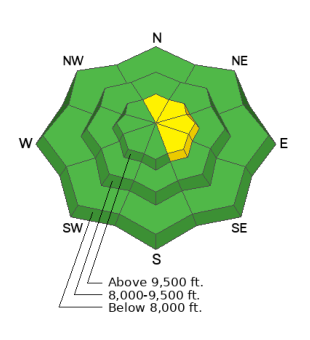

In [34]:
rose_url = uac_url + soup.find("img", class_="full-width compass-width sm-pb3").get('src')
print(rose_url)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

im = Image.open(requests.get(rose_url, stream=True).raw)

def plot_image(image, axis = False):
    plt.imshow(image)
    if not axis:
        plt.axis('off')
    plt.show()
    return

def plot_image_url(image_url, axis=False):
    im = Image.open(requests.get(image_url, stream=True).raw)
    plt.imshow(im)
    if not axis:
        plt.axis('off')
    plt.show()
    return

plot_image(im)

In [14]:
def classify_danger(rgb_tuple):
    '''takes an rgb_tuple and returns the danger rating of that color based on the minimum manhattan distance
    of the rgb value from the specific danger values linked to specific colors. 
    Low (1) -> Green, Moderate (2) -> Yellow, Considerable (3) -> Orange, High (4) -> Red, Extreme (5) -> Black
    eg. rgb_tuple = (5,255,6)-->'Green'-->'Low.'''

    colors = {1 : (0,153,0),
              2: (255, 255, 0),
              3: (255, 128, 0),
              4: (255, 0, 0),
              5 : (0, 0,0),
              0 : (160, 160, 160)
              }

    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) #uses manhatten distance
    distances = {k: manhattan(v, rgb_tuple) for k, v in colors.items()}
    danger = min(distances, key=distances.get)
    return danger

def get_rose_url(forecast_url):
    page = requests.get(forecast_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    rose_url = uac_url + soup.find("img", class_="full-width compass-width sm-pb3").get('src')
    return rose_url

def get_danger_rose(forecast_url, plot = False):
    '''identifies the avalanche danger at each aspect and elevation of the danger rose and returns a dictionary
    of the results'''
    #coordinates for each elevation and aspect
    #elevations are Low (<8000), Mid(8-95000), and High (>9500)
    #(Aspect, Elevation) = (x,y)
    rose_coord = {('N', 'High'): (200, 130),
                  ('NE', 'High') : (225, 135),
                  ('NW', 'High') : (175, 135),
                  ('W', 'High') : (165, 155),
                  ('E', 'High') : (235, 155),
                  ('SW', 'High') : (175, 175), 
                  ('S', 'High'): (200, 185), 
                  ('SE', 'High'): (225, 175), 
                  ('N', 'Mid'):(200, 100),
                  ('NE', 'Mid'):(250, 115),
                  ('NW', 'Mid'): (150, 115),
                  ('W', 'Mid'):(125, 165),
                  ('E', 'Mid'):(275, 165),
                  ('SW', 'Mid'):(145, 215), 
                  ('S', 'Mid') : (200, 230),
                  ('SE', 'Mid'):(255, 215),
                  ('N', 'Low'):(200, 65),
                  ('NE', 'Low'):(280, 100),
                  ('NW', 'Low'):(120, 100),
                  ('W', 'Low'):(75, 170),
                  ('E', 'Low'):(325, 170),
                  ('SW', 'Low'):(110, 250), 
                  ('S', 'Low'):(200, 280), 
                  ('SE', 'Low'):(290, 250)}

    rose_url = get_rose_url(forecast_url)
    rose_img = Image.open(requests.get(rose_url, stream=True).raw)
    if plot:
        plt.imshow(rose_img)
        plt.axis('off')
    rose_danger = {}
    pix = rose_img.load()
    for region in rose_coord:
        x,y = rose_coord[region]
        if plot:
            plt.plot(x, y, 'k', marker = 'o', markersize=6)
        rose_danger[region] = classify_danger(pix[x,y][0:3])
        #print(region, 'the danger is', rose_danger[region])
    if plot:
        plt.show()
    return rose_danger, rose_url

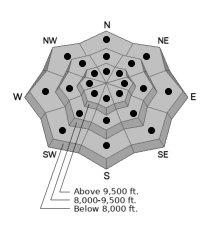

{('N', 'High'): 0, ('NE', 'High'): 0, ('NW', 'High'): 0, ('W', 'High'): 0, ('E', 'High'): 0, ('SW', 'High'): 0, ('S', 'High'): 0, ('SE', 'High'): 0, ('N', 'Mid'): 0, ('NE', 'Mid'): 0, ('NW', 'Mid'): 0, ('W', 'Mid'): 0, ('E', 'Mid'): 0, ('SW', 'Mid'): 0, ('S', 'Mid'): 0, ('SE', 'Mid'): 0, ('N', 'Low'): 0, ('NE', 'Low'): 0, ('NW', 'Low'): 0, ('W', 'Low'): 0, ('E', 'Low'): 0, ('SW', 'Low'): 0, ('S', 'Low'): 0, ('SE', 'Low'): 0} https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230427-071122-6.png


In [13]:
#rose_url = 'https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230427-071122-6.png'
danger_rose, rose_url = get_danger_rose(todays_forecast_url, plot=True)
print(danger_rose, rose_url)

#### Weather And Snow

See separate notebook

#### Avalanche Problems

In [15]:
todays_forecast_url = generate_forecast_url(TODAY, 'Salt Lake')
page = requests.get(todays_forecast_url)
soup = BeautifulSoup(page.content, 'html.parser')
print(todays_forecast_url)

https://utahavalanchecenter.org/forecast/salt-lake/4/19/2023


In [16]:
problems = soup.findAll(class_='text_01 mb0')
problem_soups = {}
for problem in problems:
    print(problem.string)
    problem_type = problem.next_sibling.nextSibling.string
    print(problem_type)
    problem_info_soup = problem.parent.parent.nextSibling.nextSibling
    problem_soups[problem.string + ': ' + problem_type] = problem_info_soup

Avalanche Problem #1
Wind Drifted Snow


In [17]:
print(list(problem_soups.keys()))
problem1_soup = problem_soups[list(problem_soups.keys())[0]]
#print(problem1_soup)

PROBLEM_FIELDS = ['Location', 'Likelihood', 'Size']
problem1_imgs = {}
for field in PROBLEM_FIELDS:
    field_tag = problem1_soup.find(string=field).parent
    print(field_tag.string)
    img_tag = field_tag.next_sibling.next_sibling
    img_source_url = uac_url + img_tag.get('src')
    print(img_source_url)
    problem1_imgs[field] = img_source_url
#[img.get('src') for img in problem1_info.findAll("img")]

['Avalanche Problem #1: Wind Drifted Snow']
Location
https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230419-064957-1.png
Likelihood
https://utahavalanchecenter.org/sites/all/themes/custom/basscss/images/icons/likelihood/likelihood_02.jpg
Size
https://utahavalanchecenter.org/sites/all/themes/custom/basscss/images/icons/size/size_01.jpg


##### Location Rose
The location rose should have the same analysis process as the Danger Rose. One note with the location rose is that more recent forecasts simply indicate where the avalanche problem is present (indicated by light blue fills on aspects & elevations). Older forecasts indicate the level of severity on the various aspects. 

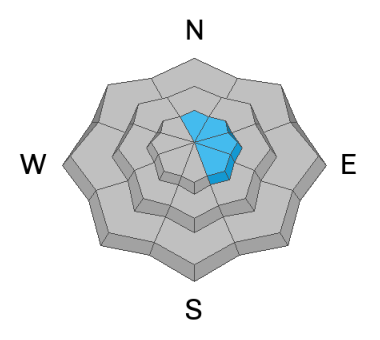

In [18]:
location_url = problem1_imgs['Location']
im = Image.open(requests.get(location_url, stream=True).raw)
plot_image(im)

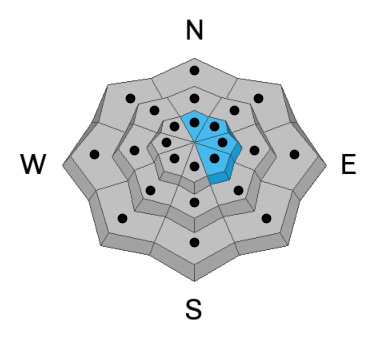

{('N', 'High'): 'Present',
 ('NE', 'High'): 'Present',
 ('NW', 'High'): 'Not Present',
 ('W', 'High'): 'Not Present',
 ('E', 'High'): 'Present',
 ('SW', 'High'): 'Not Present',
 ('S', 'High'): 'Not Present',
 ('SE', 'High'): 'Present',
 ('N', 'Mid'): 'Not Present',
 ('NE', 'Mid'): 'Not Present',
 ('NW', 'Mid'): 'Not Present',
 ('W', 'Mid'): 'Not Present',
 ('E', 'Mid'): 'Not Present',
 ('SW', 'Mid'): 'Not Present',
 ('S', 'Mid'): 'Not Present',
 ('SE', 'Mid'): 'Not Present',
 ('N', 'Low'): 'Not Present',
 ('NE', 'Low'): 'Not Present',
 ('NW', 'Low'): 'Not Present',
 ('W', 'Low'): 'Not Present',
 ('E', 'Low'): 'Not Present',
 ('SW', 'Low'): 'Not Present',
 ('S', 'Low'): 'Not Present',
 ('SE', 'Low'): 'Not Present'}

In [19]:
def get_location_rose(img_url, plot = False):
    '''identifies the avalanche problem locations at each aspect and elevation of the location rose specified by img_url 
    and returns a dictionary of the results'''
    #coordinates for each elevation and aspect
    #elevations are Low (<8000), Mid(8-95000), and High (>9500)
    #(Aspect, Elevation) = (x,y), #down->15, right-> 30
    rose_coord = {('N', 'High'): (200, 130),
                  ('NE', 'High') : (225, 135),
                  ('NW', 'High') : (175, 135),
                  ('W', 'High') : (165, 155),
                  ('E', 'High') : (235, 155),
                  ('SW', 'High') : (175, 175), 
                  ('S', 'High'): (200, 185), 
                  ('SE', 'High'): (225, 175), 
                  ('N', 'Mid'):(200, 100),
                  ('NE', 'Mid'):(250, 115),
                  ('NW', 'Mid'): (150, 115),
                  ('W', 'Mid'):(125, 165),
                  ('E', 'Mid'):(275, 165),
                  ('SW', 'Mid'):(145, 215), 
                  ('S', 'Mid') : (200, 230),
                  ('SE', 'Mid'):(255, 215),
                  ('N', 'Low'):(200, 65),
                  ('NE', 'Low'):(280, 100),
                  ('NW', 'Low'):(120, 100),
                  ('W', 'Low'):(75, 170),
                  ('E', 'Low'):(325, 170),
                  ('SW', 'Low'):(110, 250), 
                  ('S', 'Low'):(200, 280), 
                  ('SE', 'Low'):(290, 250)}
    
    #transform for location rose
    for location in list(rose_coord):
        coord = rose_coord[location]
        transformed_coord = (coord[0] + 30, coord[1] + 10)
        rose_coord[location] = transformed_coord
        
    rose_img = Image.open(requests.get(img_url, stream=True).raw)
    if plot:
        plt.imshow(rose_img)
        plt.axis('off')
    location_rose = {}
    pix = rose_img.load()
    for region in rose_coord:
        x,y = rose_coord[region]
        if plot:
            plt.plot(x, y, 'k', marker = 'o', markersize=6)
        location_rose[region] = classify_presence(pix[x,y][0:3])
        #print(region, 'the danger is', rose_danger[region])
    if plot:
        plt.show()
    return location_rose

def classify_presence(rgb_tuple):
    '''Similar to classify_danger function
    Present(blue) and Not Present(grey) categories indicate location of avy problem'''

    colors = {
              "Present" : (102, 178, 255),
              "Not Present" : (192, 192, 192)
              }

    manhattan = lambda x,y : abs(x[0] - y[0]) + abs(x[1] - y[1]) + abs(x[2] - y[2]) #uses manhatten distance
    distances = {k: manhattan(v, rgb_tuple) for k, v in colors.items()}
    location = min(distances, key=distances.get)
    return location

get_location_rose(location_url, plot=True)

##### Likelihood and Size Figures

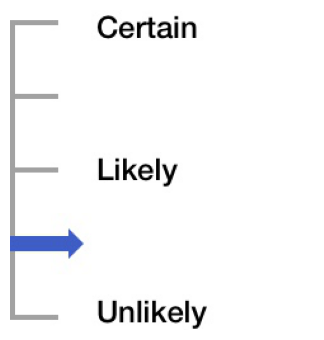

In [20]:
likelihood_url = problem1_imgs['Likelihood']
size_url = problem1_imgs['Size']
im_likelihood = Image.open(requests.get(likelihood_url, stream=True).raw)
im_size = Image.open(requests.get(size_url, stream = True).raw)
plot_image(im_likelihood)

In [21]:
def measure_likelihood(img_url, plot = False):
    #coordinates of each certainty category
    #Certainty, certainty_factor = (x,y)
    scale_coord = {('Certain', 5): (35, 9),
                   ('Very Likely', 4) : (35, 68),
                  ('Likely', 3) : (35, 125),
                  ('Somewhat Likely', 2) : (35, 183),
                  ('Unlikely', 1) : (35, 241),
                  }


    scale_reading = {}
    img_likelihood = Image.open(requests.get(img_url, stream=True).raw)
    if plot:
        plt.imshow(img_likelihood)
        plt.axis('off')
    pix = img_likelihood.load()
    for likelihood in scale_coord:
        x,y = scale_coord[likelihood]
        if plot:
            plt.plot(x, y, 'k', marker = 'o', markersize=6)
        scale_reading[likelihood] = classify_presence(pix[x,y][0:3])
        #print(likelihood, 'coordinates are', scale_coord[likelihood], 'and which reads as',scale_reading[likelihood])
        if scale_reading[likelihood] == 'Present':
            likelihood, likelihood_factor = likelihood
            return likelihood, likelihood_factor
    return None

def measure_size(img_url, plot = False):
    #coordinates of each certainty category
    #Certainty, certainty_factor = (x,y)
    scale_coord = {('Large', 5): (35, 9),
                   ('Medium-Large', 4) : (35, 68),
                  ('Medium', 3) : (35, 125),
                  ('Medium-Small', 2) : (35, 183),
                  ('Small', 1) : (35, 241),
                  }


    scale_reading = {}
    img_size = Image.open(requests.get(img_url, stream=True).raw)
    if plot:
        plt.imshow(img_size)
        plt.axis('off')
    pix = img_size.load()
    for size in scale_coord:
        x,y = scale_coord[size]
        if plot:
            plt.plot(x, y, 'k', marker = 'o', markersize=6)
        scale_reading[size] = classify_presence(pix[x,y][0:3])
        #print(size, 'coordinates are', scale_coord[size], 'and which reads as',scale_reading[size])
        if scale_reading[size] == 'Present':
            size, size_factor = size
            return size, size_factor
    return None

In [22]:
def read_avalanche_problems(forecast_url):
    '''collects the type, location, likelihood, size, and description of each avalanche problem
    returns a dictionary of each problem with problem info'''
    page = requests.get(forecast_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    problems = soup.findAll(class_='text_01 mb0')
    avalanche_problems = {}
    for problem in problems:
        problem_type = problem.next_sibling.nextSibling.string
        #print(problem.string, problem_type)
        problem_info_soup = problem.parent.parent.nextSibling.nextSibling
        
        problem_info = read_problem_fields(problem_info_soup) #dictionary of problem information
        problem_info['Type'] = problem_type
        avalanche_problems[problem.string] = problem_info
        
    return avalanche_problems

def read_problem_fields(problem_soup):
    '''returns a dictionary of information contained in an forcast's avalanche problem'''
    problem_info = {}
    PROBLEM_FIELDS = ['Location', 'Likelihood', 'Size', 'Description']
    for field in PROBLEM_FIELDS:
        if field == 'Description':
            # get the description and insert into problem_info
            description = problem_soup.find(string=field).parent.next_sibling.next_sibling.contents[1].string
            #print('Description:',description)
            problem_info[field] = description
        else:
            field_tag = problem_soup.find(string=field).parent
            #print(field_tag)
            img_tag = field_tag.next_sibling.next_sibling
            img_url = uac_url + img_tag.get('src')
            #print(img_url)
            problem_info[field] = get_field_info(img_url, field)
            if field == 'Location':
                problem_info['Location Image Url'] = img_url
    return problem_info

def get_field_info(img_url, field):
    '''extracts field information from the image linked to the img_url. Field information is either location rose data, 
    likelihood, or size'''
    if field == 'Location':
        #get Location Rose
        field_info = get_location_rose(img_url) #dictionary of aspect and elevations with risk levels
    elif field == 'Likelihood':
        #read likelihood figure
        field_info = measure_likelihood(img_url) #Unlikely, Likely, Certain (1-5)
    else:
        #read size figure
        field_info = measure_size(img_url) # Small - Medium - Large (1-5)
    return field_info

avalanche_problems = read_avalanche_problems(todays_forecast_url)
for problem in list(avalanche_problems):
    print(problem, avalanche_problems[problem], '\n')

Avalanche Problem #1 {'Location': {('N', 'High'): 'Present', ('NE', 'High'): 'Present', ('NW', 'High'): 'Not Present', ('W', 'High'): 'Not Present', ('E', 'High'): 'Present', ('SW', 'High'): 'Not Present', ('S', 'High'): 'Not Present', ('SE', 'High'): 'Present', ('N', 'Mid'): 'Not Present', ('NE', 'Mid'): 'Not Present', ('NW', 'Mid'): 'Not Present', ('W', 'Mid'): 'Not Present', ('E', 'Mid'): 'Not Present', ('SW', 'Mid'): 'Not Present', ('S', 'Mid'): 'Not Present', ('SE', 'Mid'): 'Not Present', ('N', 'Low'): 'Not Present', ('NE', 'Low'): 'Not Present', ('NW', 'Low'): 'Not Present', ('W', 'Low'): 'Not Present', ('E', 'Low'): 'Not Present', ('SW', 'Low'): 'Not Present', ('S', 'Low'): 'Not Present', ('SE', 'Low'): 'Not Present'}, 'Location Image Url': 'https://utahavalanchecenter.org/sites/default/files/forecast/202304/20230419-064957-1.png', 'Likelihood': ('Somewhat Likely', 2), 'Size': ('Small', 1), 'Description': None, 'Type': 'Wind Drifted Snow'} 



## Formating Data into Dataframe

In [23]:
#what I want to do is find a pythonic (pandic?, pythandic?) way to output
problems = pd.Series(dtype='object')
for problem in list(avalanche_problems):
    for field in list(avalanche_problems[problem]):
        column_name = f"{problem}:{field}"
        problems[column_name]=avalanche_problems[problem][field]
problems

Avalanche Problem #1:Location              {('N', 'High'): 'Present', ('NE', 'High'): 'Pr...
Avalanche Problem #1:Location Image Url    https://utahavalanchecenter.org/sites/default/...
Avalanche Problem #1:Likelihood                                         (Somewhat Likely, 2)
Avalanche Problem #1:Size                                                         (Small, 1)
Avalanche Problem #1:Description                                                        None
Avalanche Problem #1:Type                                                  Wind Drifted Snow
dtype: object

In [24]:
def avalanche_problems_to_series(avalanche_problems):
    problems = pd.Series(dtype='object')
    for problem in list(avalanche_problems):
        for field in list(avalanche_problems[problem]):
            column_name = f"{problem}:{field}"
            problems[column_name]=avalanche_problems[problem][field]
    return problems

In [25]:
def get_forecast(date, region):
    '''Returns a dataframe entry holding: Date, Region, Danger Rose Dictionary, Danger Rose image url,
    and numerated avalanche problems (whose data is stored in dictionaries).'''
    forecast_url = generate_forecast_url(date, region)
    forecast = pd.Series(dtype='object')
    forecast['Date'] = date
    forecast['Region'] = region
    danger_rose, rose_url = get_danger_rose(forecast_url)
    forecast['Danger Rose'] = danger_rose
    forecast['Danger Rose URL'] = rose_url
    avalanche_problems = avalanche_problems_to_series(read_avalanche_problems(forecast_url))
    forecast = pd.concat([forecast, avalanche_problems])
    return forecast
        
get_forecast(TODAY, 'Salt Lake')    

Date                                                                              2023-04-19
Region                                                                             Salt Lake
Danger Rose                                {('N', 'High'): 'Moderate', ('NE', 'High'): 'M...
Danger Rose URL                            https://utahavalanchecenter.org/sites/default/...
Avalanche Problem #1:Location              {('N', 'High'): 'Present', ('NE', 'High'): 'Pr...
Avalanche Problem #1:Location Image Url    https://utahavalanchecenter.org/sites/default/...
Avalanche Problem #1:Likelihood                                         (Somewhat Likely, 2)
Avalanche Problem #1:Size                                                         (Small, 1)
Avalanche Problem #1:Description                                                        None
Avalanche Problem #1:Type                                                  Wind Drifted Snow
dtype: object

In [26]:
get_forecast(TODAY - datetime.timedelta(days=1), 'Salt Lake')

Date                                                                              2023-04-18
Region                                                                             Salt Lake
Danger Rose                                {('N', 'High'): 'Moderate', ('NE', 'High'): 'M...
Danger Rose URL                            https://utahavalanchecenter.org/sites/default/...
Avalanche Problem #1:Location              {('N', 'High'): 'Present', ('NE', 'High'): 'Pr...
Avalanche Problem #1:Location Image Url    https://utahavalanchecenter.org/sites/default/...
Avalanche Problem #1:Likelihood                                         (Somewhat Likely, 2)
Avalanche Problem #1:Size                                                  (Medium-Small, 2)
Avalanche Problem #1:Description                                                        None
Avalanche Problem #1:Type                                                           New Snow
Avalanche Problem #2:Location              {('N', 'High'): 'Present', 

In [27]:
date = TODAY - datetime.timedelta(days = 14)
region = 'Salt Lake'
df = pd.DataFrame()
while date <= TODAY:
    #print(date)
    date_forecast = get_forecast(date, region)
    #print(date_forecast)
    df = pd.concat([df,date_forecast], axis=1)
    date += datetime.timedelta(days=1)
df.T.reset_index(drop=True)

,Date,Region,Danger Rose,Danger Rose URL,Avalanche Problem #1:Location,Avalanche Problem #1:Location Image Url,Avalanche Problem #1:Likelihood,Avalanche Problem #1:Size,Avalanche Problem #1:Description,Avalanche Problem #1:Type,...,Avalanche Problem #2:Likelihood,Avalanche Problem #2:Size,Avalanche Problem #2:Description,Avalanche Problem #2:Type,Avalanche Problem #3:Location,Avalanche Problem #3:Location Image Url,Avalanche Problem #3:Likelihood,Avalanche Problem #3:Size,Avalanche Problem #3:Description,Avalanche Problem #3:Type
0,2023-04-05,Salt Lake,"{('N', 'High'): 'High', ('NE', 'High'): 'High'...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Very Likely, 4)","(Medium, 3)",There have and will continue to be soft slab a...,New Snow,...,"(Very Likely, 4)","(Medium, 3)",None,Wind Drifted Snow,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-06,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Likely, 3)","(Medium, 3)",None,Wet Snow,...,"(Likely, 3)","(Medium, 3)",There should be slabs of wind drifted snow at ...,Wind Drifted Snow,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium, 3)",None,New Snow
2,2023-04-07,Salt Lake,"{('N', 'High'): 'Moderate', ('NE', 'High'): 'M...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Likely, 3)","(Medium, 3)",None,Wet Snow,...,"(Somewhat Likely, 2)","(Medium, 3)",None,Cornice,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium-Small, 2)",Although instabilities within the recent storm...,New Snow
3,2023-04-08,Salt Lake,"{('N', 'High'): 'Moderate', ('NE', 'High'): 'M...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium, 3)",None,Wet Snow,...,"(Somewhat Likely, 2)","(Medium-Small, 2)",None,Wind Drifted Snow,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium, 3)",None,Cornice
4,2023-04-09,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Likely, 3)","(Medium, 3)",This morning you can expect a shallow re-freez...,Wet Snow,...,"(Likely, 3)","(Medium, 3)",None,Cornice,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-04-10,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Very Likely, 4)","(Medium-Large, 4)",This morning you can expect to see a shallow r...,Wet Snow,...,"(Likely, 3)","(Medium, 3)",None,Cornice,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium-Large, 4)",None,Gliding Snow
6,2023-04-11,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Very Likely, 4)","(Medium-Large, 4)",None,Wet Snow,...,"(Likely, 3)","(Large, 5)",None,Cornice,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Unlikely, 1)","(Medium-Large, 4)",None,Gliding Snow
7,2023-04-12,Salt Lake,"{('N', 'High'): 'High', ('NE', 'High'): 'High'...",https://utahavalanchecenter.org/sites/def

In [28]:
def get_forecasts(start_date= get_season_start(TODAY), end_date=TODAY, region= 'Salt Lake'):
    '''returns dataframe of forecast fieds from the start_date to end date. Defaults to season's forecasts for
    salt lake'''
    date = start_date
    forecasts = pd.DataFrame()
    while date <= TODAY:
        #print(date)
        date_forecast = get_forecast(date, region)
        #print(date_forecast)
        forecasts = pd.concat([forecasts,date_forecast], axis=1)
        date += datetime.timedelta(days=1)
    forecasts=forecasts.T.reset_index(drop=True)
    return forecasts

past_2w = get_forecasts(start_date = TODAY - datetime.timedelta(days=14), end_date =TODAY, region='Salt Lake')
past_2w.loc[0:5]

,Date,Region,Danger Rose,Danger Rose URL,Avalanche Problem #1:Location,Avalanche Problem #1:Location Image Url,Avalanche Problem #1:Likelihood,Avalanche Problem #1:Size,Avalanche Problem #1:Description,Avalanche Problem #1:Type,...,Avalanche Problem #2:Likelihood,Avalanche Problem #2:Size,Avalanche Problem #2:Description,Avalanche Problem #2:Type,Avalanche Problem #3:Location,Avalanche Problem #3:Location Image Url,Avalanche Problem #3:Likelihood,Avalanche Problem #3:Size,Avalanche Problem #3:Description,Avalanche Problem #3:Type
0,2023-04-05,Salt Lake,"{('N', 'High'): 'High', ('NE', 'High'): 'High'...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Very Likely, 4)","(Medium, 3)",There have and will continue to be soft slab a...,New Snow,...,"(Very Likely, 4)","(Medium, 3)",None,Wind Drifted Snow,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-06,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Likely, 3)","(Medium, 3)",None,Wet Snow,...,"(Likely, 3)","(Medium, 3)",There should be slabs of wind drifted snow at ...,Wind Drifted Snow,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium, 3)",None,New Snow
2,2023-04-07,Salt Lake,"{('N', 'High'): 'Moderate', ('NE', 'High'): 'M...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Likely, 3)","(Medium, 3)",None,Wet Snow,...,"(Somewhat Likely, 2)","(Medium, 3)",None,Cornice,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium-Small, 2)",Although instabilities within the recent storm...,New Snow
3,2023-04-08,Salt Lake,"{('N', 'High'): 'Moderate', ('NE', 'High'): 'M...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium, 3)",None,Wet Snow,...,"(Somewhat Likely, 2)","(Medium-Small, 2)",None,Wind Drifted Snow,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium, 3)",None,Cornice
4,2023-04-09,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Likely, 3)","(Medium, 3)",This morning you can expect a shallow re-freez...,Wet Snow,...,"(Likely, 3)","(Medium, 3)",None,Cornice,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-04-10,Salt Lake,"{('N', 'High'): 'Considerable', ('NE', 'High')...",https://utahavalanchecenter.org/sites/default/...,"{('N', 'High'): 'Not Present', ('NE', 'High'):...",https://utahavalanchecenter.org/sites/default/...,"(Very Likely, 4)","(Medium-Large, 4)",This morning you can expect to see a shallow r...,Wet Snow,...,"(Likely, 3)","(Medium, 3)",None,Cornice,"{('N', 'High'): 'Present', ('NE', 'High'): 'Pr...",https://utahavalanchecenter.org/sites/default/...,"(Somewhat Likely, 2)","(Medium-Large, 4)",None,Gliding Snow


In [29]:
print(past_2w.sort_values('Date', ascending=False).reset_index(drop=True).head())

         Date     Region                                        Danger Rose  \
0  2023-04-19  Salt Lake  {('N', 'High'): 'Moderate', ('NE', 'High'): 'M...   
1  2023-04-18  Salt Lake  {('N', 'High'): 'Moderate', ('NE', 'High'): 'M...   
2  2023-04-17  Salt Lake  {('N', 'High'): 'Low', ('NE', 'High'): 'Low', ...   
3  2023-04-16  Salt Lake  {('N', 'High'): 'Low', ('NE', 'High'): 'Low', ...   
4  2023-04-15  Salt Lake  {('N', 'High'): 'Low', ('NE', 'High'): 'Low', ...   

                                     Danger Rose URL  \
0  https://utahavalanchecenter.org/sites/default/...   
1  https://utahavalanchecenter.org/sites/default/...   
2  https://utahavalanchecenter.org/sites/default/...   
3  https://utahavalanchecenter.org/sites/default/...   
4  https://utahavalanchecenter.org/sites/default/...   

                       Avalanche Problem #1:Location  \
0  {('N', 'High'): 'Present', ('NE', 'High'): 'Pr...   
1  {('N', 'High'): 'Present', ('NE', 'High'): 'Pr...   
2  {('N', 'High'): '

{('N', 'High'): 'Moderate', ('NE', 'High'): 'Moderate', ('NW', 'High'): 'Low', ('W', 'High'): 'Low', ('E', 'High'): 'Moderate', ('SW', 'High'): 'Low', ('S', 'High'): 'Low', ('SE', 'High'): 'Moderate', ('N', 'Mid'): 'Low', ('NE', 'Mid'): 'Low', ('NW', 'Mid'): 'Low', ('W', 'Mid'): 'Low', ('E', 'Mid'): 'Low', ('SW', 'Mid'): 'Low', ('S', 'Mid'): 'Low', ('SE', 'Mid'): 'Low', ('N', 'Low'): 'Low', ('NE', 'Low'): 'Low', ('NW', 'Low'): 'Low', ('W', 'Low'): 'Low', ('E', 'Low'): 'Low', ('SW', 'Low'): 'Low', ('S', 'Low'): 'Low', ('SE', 'Low'): 'Low'}


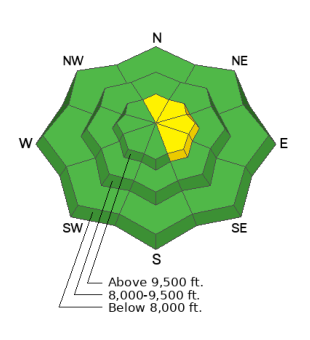

In [35]:
print(past_2w.loc[14]['Danger Rose'])
plot_image_url(past_2w.iloc[-1]['Danger Rose URL'])

In [36]:
season_forecasts = get_forecasts()

AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
season_forecasts.head()